Bayesian structural timeseries models are an interesting way to learn about the structure inherent in any observed timeseries data. It also gives us the ability to project forward the implied predictive distribution granting us another view on forecasting problems. We can treat the learned characteristics of the timeseries data observed to-date as informative about the structure of the unrealised future state of the same measure.

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm

from matplotlib import pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
RANDOM_SEED = 8929
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Stimulate Data from Model

We stimulatee data from AR time series - then add complexities to show how they too can be captured with an AR model.

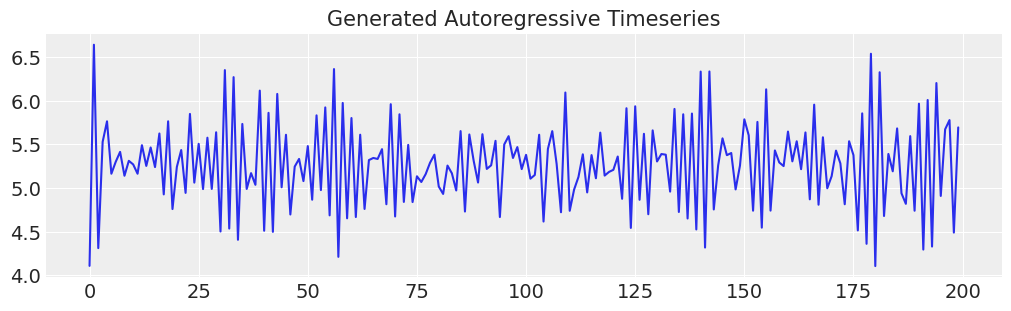

In [3]:
def simulate_ar(intercept, coef1, coef2, noise=0.3, *, warmup=10, steps=200):
    # We sample some extra warmup steps, to let the AR process stabilize
    draws = np.zeros(warmup + steps)
    # Initialize first draws at intercept
    draws[:2] = intercept
    for step in range(2, warmup + steps):
        draws[step] = (
            intercept
            + coef1 * draws[step - 1]
            + coef2 * draws[step - 2]
            + np.random.normal(0, noise)
        )
    # Discard the warmup draws
    return draws[warmup:]


# True parameters of the AR process
ar1_data = simulate_ar(10, -0.9, 0)

fig, ax = plt.subplots(figsize=(10, 3))
ax.set_title("Generated Autoregressive Timeseries", fontsize=15)
ax.plot(ar1_data);

## Specifying the Model

In [4]:
## Set up a dictionary for the specification of our priors
## We set up the dictionary to specify size of the AR coefficients in
## case we want to vary the AR lags.
priors = {
    "coefs": {"mu": [10, 0.2], "sigma": [0.1, 0.1], "size": 2},
    "sigma": 8,
    "init": {"mu": 9, "sigma": 0.1, "size": 1},
}

## Initialise the model
with pm.Model() as AR:
    pass

## Define the time interval for fitting the data
t_data = list(range(len(ar1_data)))
## Add the time interval as a mutable coordinate to the model to allow for future predictions
AR.add_coord("obs_id", t_data, mutable=True)

with AR:
    ## Data containers to enable prediction
    t = pm.MutableData("t", t_data, dims="obs_id")
    y = pm.MutableData("y", ar1_data, dims="obs_id")

    # The first coefficient will be the constant term but we need to set priors for each coefficient in the AR process
    coefs = pm.Normal("coefs", priors["coefs"]["mu"], priors["coefs"]["sigma"])
    sigma = pm.HalfNormal("sigma", priors["sigma"])
    # We need one init variable for each lag, hence size is variable too
    init = pm.Normal.dist(
        priors["init"]["mu"], priors["init"]["sigma"], size=priors["init"]["size"]
    )
    # Steps of the AR model minus the lags required
    ar1 = pm.AR(
        "ar",
        coefs,
        sigma=sigma,
        init_dist=init,
        constant=True,
        steps=t.shape[0] - (priors["coefs"]["size"] - 1),
        dims="obs_id",
    )

    # The Likelihood
    outcome = pm.Normal("likelihood", mu=ar1, sigma=sigma, observed=y, dims="obs_id")
    ## Sampling
    idata_ar = pm.sample_prior_predictive()
    idata_ar.extend(pm.sample(2000, random_seed=100, target_accept=0.95))
    idata_ar.extend(pm.sample_posterior_predictive(idata_ar))
    

Sampling: [ar, coefs, likelihood, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coefs, sigma, ar]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 65 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [likelihood]


In [5]:
idata_ar

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

Looking at the model structure using plate notation:

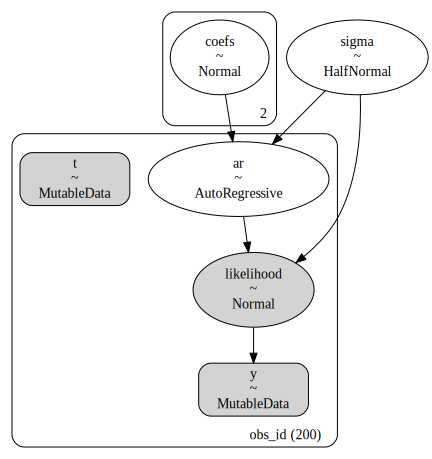

In [6]:
pm.model_to_graphviz(AR)

Convergence diagnostics:

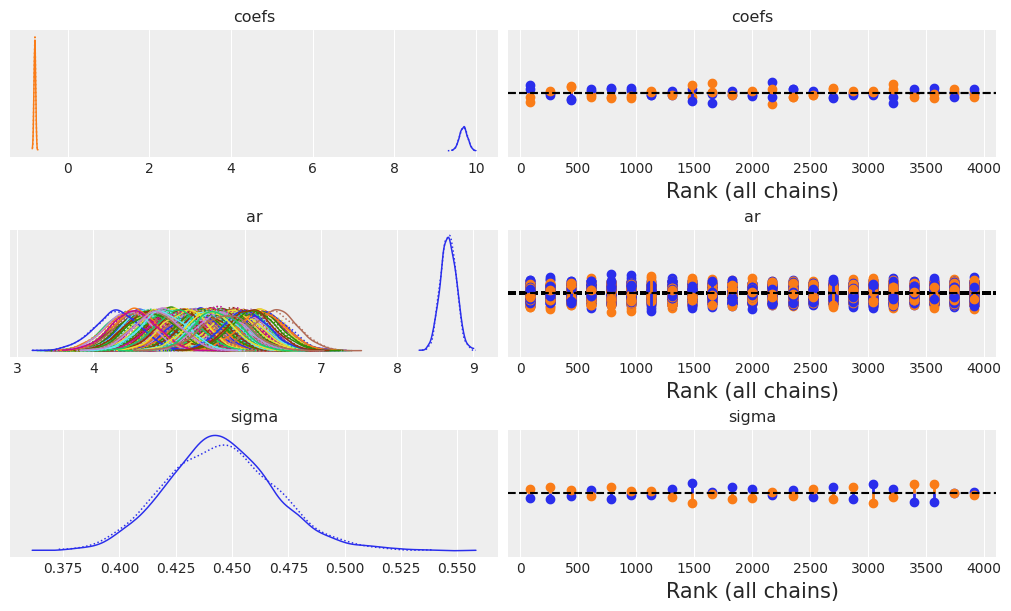

In [7]:
az.plot_trace(idata_ar, figsize=(10, 6), kind="rank_vlines");

Next we’ll check the summary estimates for the to AR coefficients and the sigma term.

In [8]:
az.summary(idata_ar, var_names=["~ar"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[0],9.697,0.097,9.524,9.887,0.001,0.001,6662.0,2896.0,1.0
coefs[1],-0.807,0.021,-0.846,-0.769,0.000,0.000,5001.0,2919.0,1.0
sigma,0.445,0.024,0.399,0.490,0.001,0.000,1876.0,2746.0,1.0


 We can also see this if we plot the posterior ar distribution against our observed data.

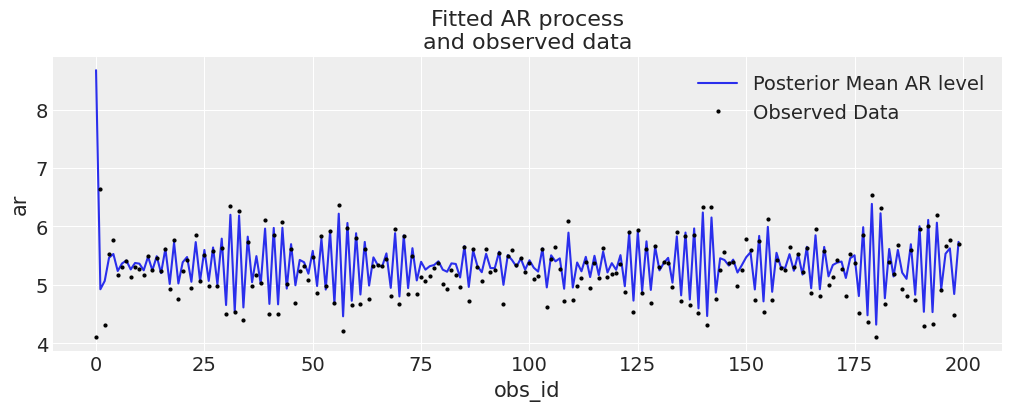

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
idata_ar.posterior.ar.mean(["chain", "draw"]).plot(ax=ax, label="Posterior Mean AR level")
ax.plot(ar1_data, "o", color="black", markersize=2, label="Observed Data")
ax.legend()
ax.set_title("Fitted AR process\nand observed data");

## Predictions:


The next step works somewhat differently from generating posterior predictive observations for new data in a GLM model. Since we are forecasting from a learned posterior distribution of structural parameters we must condition on the learned parameters. Or put another way, we have to tell the model how many prediction steps we want to impute with the model we have just fit and from what basis to impute those values.

So for the shape handling purposes we have to feed our model new data for prediction and specify how to incorporate the learned parameters of the AR process. To do so, we initialise a new AR process for the future and feed it a set of initialising values we have learned when fitting our model to data. To make this as precise as can be use use the Dirac distribution to constrain the initial AR values very tightly around the learned posterior parameters.

In [10]:
prediction_length = 250
n = prediction_length - ar1_data.shape[0]
obs = list(range(prediction_length))
with AR:
    ## We need to have coords for the observations minus the lagged term to correctly centre the prediction step
    AR.add_coords({"obs_id_fut_1": range(ar1_data.shape[0] - 1, 250, 1)})
    AR.add_coords({"obs_id_fut": range(ar1_data.shape[0], 250, 1)})
    # condition on the learned values of the AR process
    # initialise the future AR process precisely at the last observed value in the AR process
    # using the special feature of the dirac delta distribution to be 0 everywhere else.
    ar1_fut = pm.AR(
        "ar1_fut",
        init_dist=pm.DiracDelta.dist(ar1[..., -1]),
        rho=coefs,
        sigma=sigma,
        constant=True,
        dims="obs_id_fut_1",
    )
    yhat_fut = pm.Normal("yhat_fut", mu=ar1_fut[1:], sigma=sigma, dims="obs_id_fut")
    # use the updated values and predict outcomes and probabilities:
    idata_preds = pm.sample_posterior_predictive(
        idata_ar, var_names=["likelihood", "yhat_fut"], predictions=True, random_seed=100
    )

Sampling: [ar1_fut, likelihood, yhat_fut]


It’s important to understand the conditional nature of the autoregressive forecast and the manner in which it depends on the observed data. In our two-step model fit and predict process we have learned the posterior distribution for the parameters of an AR process, and then used those parameters to centre our forecasts.

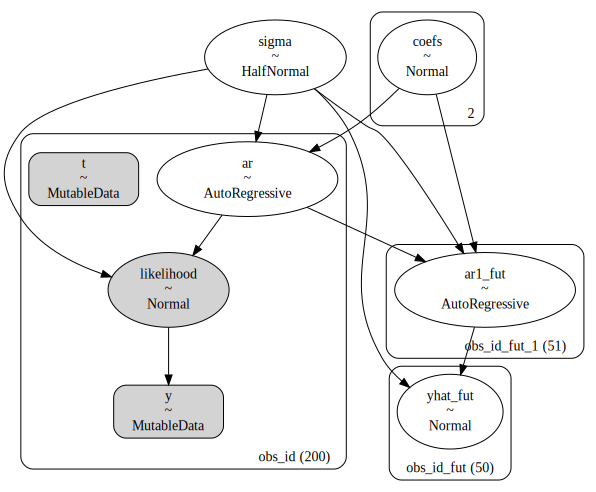

In [11]:
pm.model_to_graphviz(AR)

In [12]:
idata_preds

Inference data with groups:
	> predictions
	> predictions_constant_data

## Inspecting model fit and forecast

We can look at the standard posterior predictive fits but since our data is timeseries data we have to also look how draws from the posterior predictive distribution vary over time.

/var/tmp/ipykernel_3009/119498147.py:12: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(idata_ar, group="prior_predictive", num_samples=1000)["likelihood"],
/var/tmp/ipykernel_3009/119498147.py:17: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(idata_ar, group="prior_predictive", num_samples=1000)["likelihood"],
/var/tmp/ipykernel_3009/119498147.py:31: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(idata_ar, group="prior_predictive", num_samples=1000)["likelihood"].mean(
/var/tmp/ipykernel_3009/119498147.py:49: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(idata_preds, group="predictions", num_samples=1000)["likelihood"],
/var/tmp/ipykernel_3009/119498147.py:54: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(idata_preds, group="predictions", num_samples=1000)["lik

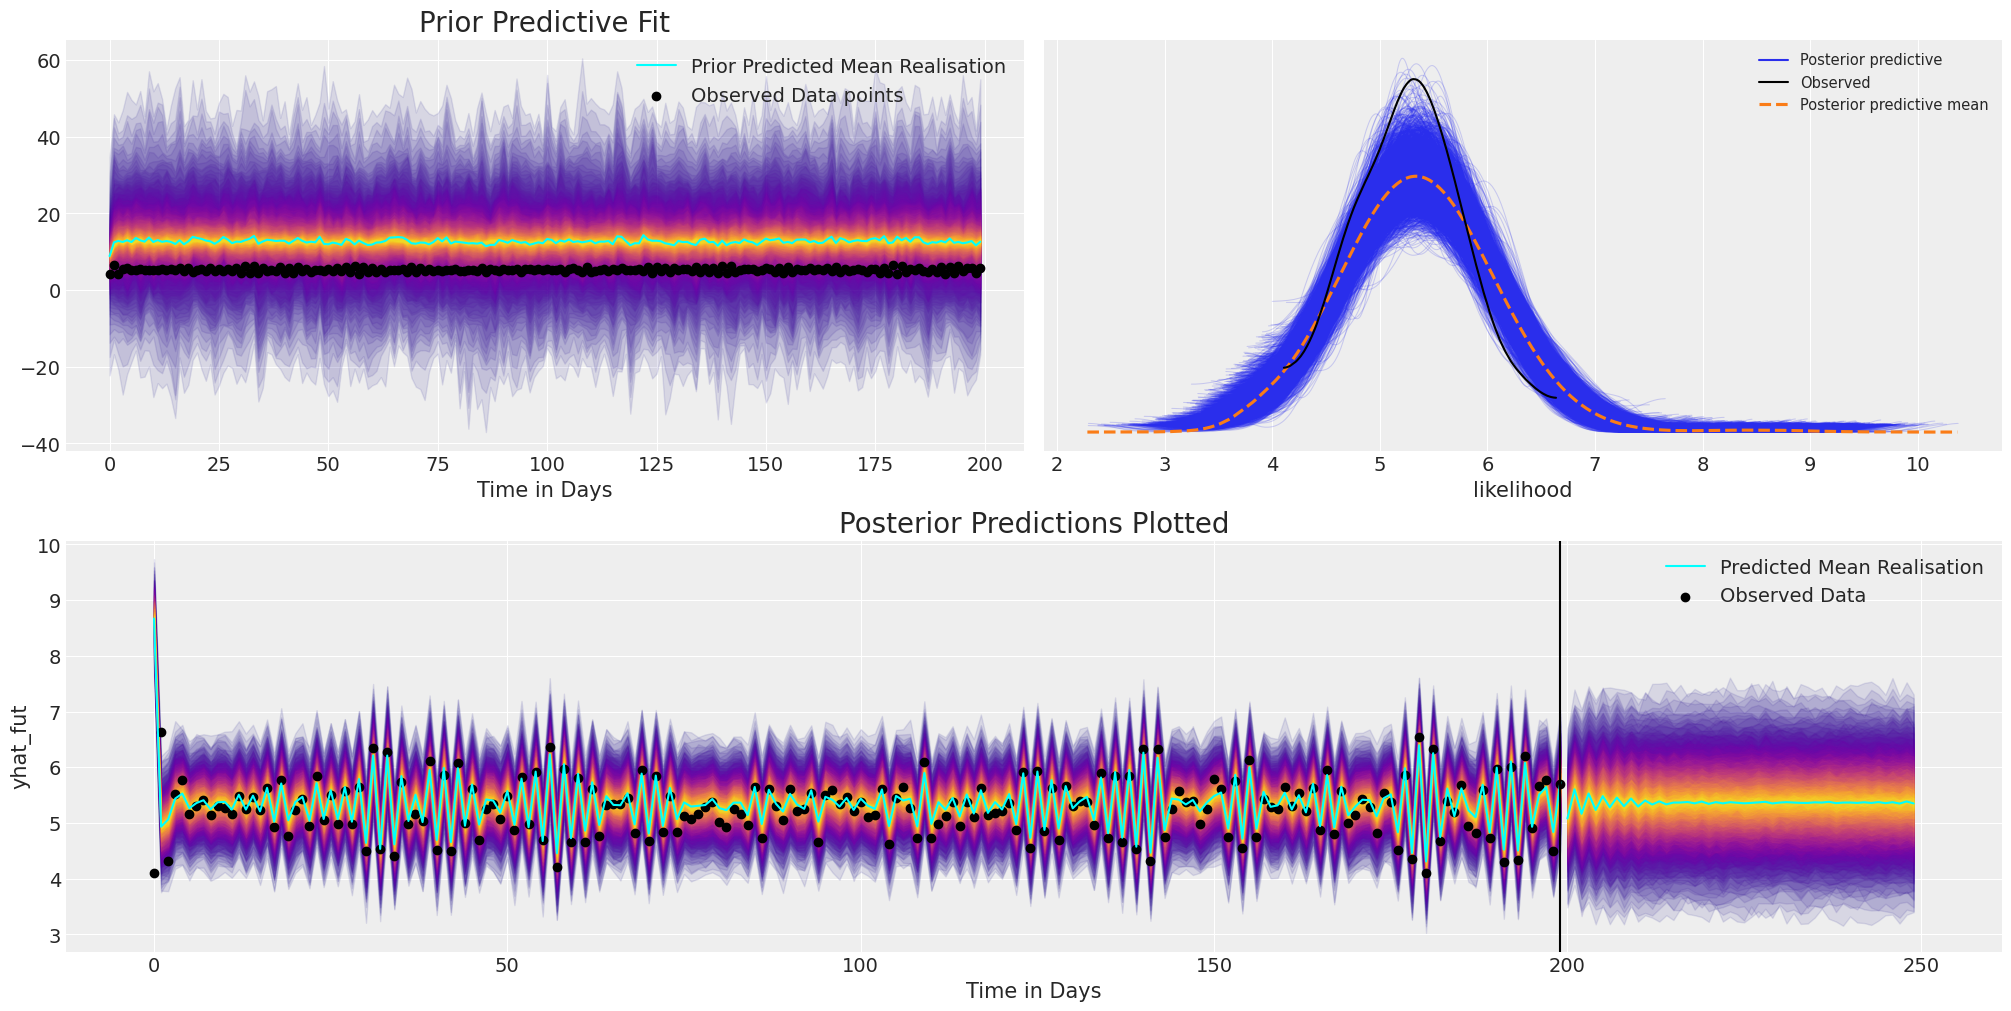

In [13]:
def plot_fits(idata_ar, idata_preds):
    palette = "plasma"
    cmap = plt.get_cmap(palette)
    percs = np.linspace(51, 99, 100)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    mosaic = """AABB
                CCCC"""
    fig, axs = plt.subplot_mosaic(mosaic, sharex=False, figsize=(20, 10))
    axs = [axs[k] for k in axs.keys()]
    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(
            az.extract_dataset(idata_ar, group="prior_predictive", num_samples=1000)["likelihood"],
            p,
            axis=1,
        )
        lower = np.percentile(
            az.extract_dataset(idata_ar, group="prior_predictive", num_samples=1000)["likelihood"],
            100 - p,
            axis=1,
        )
        color_val = colors[i]
        axs[0].fill_between(
            x=idata_ar["constant_data"]["t"],
            y1=upper.flatten(),
            y2=lower.flatten(),
            color=cmap(color_val),
            alpha=0.1,
        )

    axs[0].plot(
        az.extract_dataset(idata_ar, group="prior_predictive", num_samples=1000)["likelihood"].mean(
            axis=1
        ),
        color="cyan",
        label="Prior Predicted Mean Realisation",
    )

    axs[0].scatter(
        x=idata_ar["constant_data"]["t"],
        y=idata_ar["constant_data"]["y"],
        color="k",
        label="Observed Data points",
    )
    axs[0].set_title("Prior Predictive Fit", fontsize=20)
    axs[0].legend()

    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(
            az.extract_dataset(idata_preds, group="predictions", num_samples=1000)["likelihood"],
            p,
            axis=1,
        )
        lower = np.percentile(
            az.extract_dataset(idata_preds, group="predictions", num_samples=1000)["likelihood"],
            100 - p,
            axis=1,
        )
        color_val = colors[i]
        axs[2].fill_between(
            x=idata_preds["predictions_constant_data"]["t"],
            y1=upper.flatten(),
            y2=lower.flatten(),
            color=cmap(color_val),
            alpha=0.1,
        )

        upper = np.percentile(
            az.extract_dataset(idata_preds, group="predictions", num_samples=1000)["yhat_fut"],
            p,
            axis=1,
        )
        lower = np.percentile(
            az.extract_dataset(idata_preds, group="predictions", num_samples=1000)["yhat_fut"],
            100 - p,
            axis=1,
        )
        color_val = colors[i]
        axs[2].fill_between(
            x=idata_preds["predictions"].coords["obs_id_fut"].data,
            y1=upper.flatten(),
            y2=lower.flatten(),
            color=cmap(color_val),
            alpha=0.1,
        )

    axs[2].plot(
        az.extract_dataset(idata_preds, group="predictions", num_samples=1000)["likelihood"].mean(
            axis=1
        ),
        color="cyan",
    )
    idata_preds.predictions.yhat_fut.mean(["chain", "draw"]).plot(
        ax=axs[2], color="cyan", label="Predicted Mean Realisation"
    )
    axs[2].scatter(
        x=idata_ar["constant_data"]["t"],
        y=idata_ar["constant_data"]["y"],
        color="k",
        label="Observed Data",
    )
    axs[2].set_title("Posterior Predictions Plotted", fontsize=20)
    axs[2].axvline(np.max(idata_ar["constant_data"]["t"]), color="black")
    axs[2].legend()
    axs[2].set_xlabel("Time in Days")
    axs[0].set_xlabel("Time in Days")
    az.plot_ppc(idata_ar, ax=axs[1])


plot_fits(idata_ar, idata_preds)

Here we can see that although the model converged and ends up with a reasonable fit to the existing data, and a plausible projection for future values. However, we have set the prior specification very poorly in allowing an absurdly broad range of values due to the kind of compounding logic of the auto-regressive function. For this reason it’s very important to be able to inspect and tailor your model with prior predictive checks.

Secondly, the mean forecast fails to capture any long lasting structure, quickly dying down to a stable baseline.

## Adding Trend to Stimulated Data

Often our data will involve more than one latent process, and might have more complex factors which drive the outcomes. To see one such complication let’s add a trend to our data. By adding more structure to our forecast we are telling our model that we expect certain patterns or trends to remain in the data out into the future. The choice of which structures to add are at the discretion of the creative modeller - here we’ll demonstrate some simple examples.

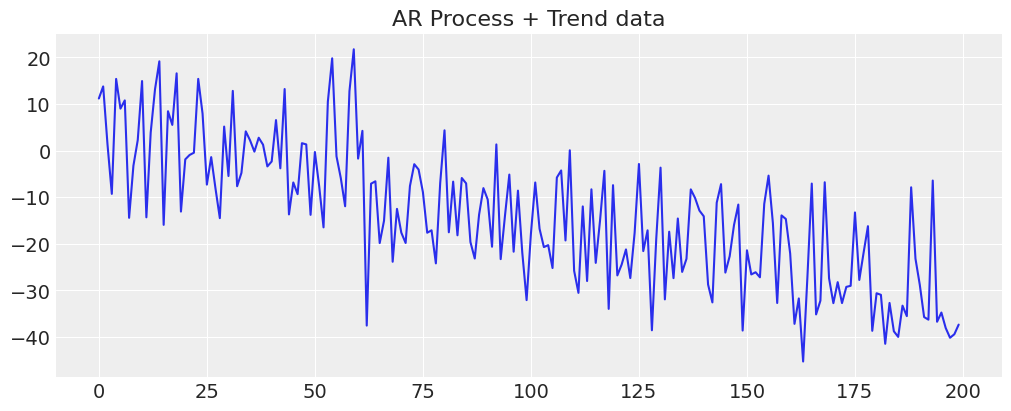

In [14]:
y_t = -0.3 + np.arange(200) * -0.2 + np.random.normal(0, 10, 200)
y_t = y_t + ar1_data

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y_t)
ax.set_title("AR Process + Trend data");

### Wrap model into a function

In [15]:
def make_latent_AR_model(ar_data, priors, prediction_steps=250, full_sample=True, samples=2000):
    with pm.Model() as AR:
        pass

    t_data = list(range(len(ar_data)))
    AR.add_coord("obs_id", t_data, mutable=True)

    with AR:
        ## Data containers to enable prediction
        t = pm.MutableData("t", t_data, dims="obs_id")
        y = pm.MutableData("y", ar_data, dims="obs_id")
        # The first coefficient will be the intercept term
        coefs = pm.Normal("coefs", priors["coefs"]["mu"], priors["coefs"]["sigma"])
        sigma = pm.HalfNormal("sigma", priors["sigma"])
        # We need one init variable for each lag, hence size is variable too
        init = pm.Normal.dist(
            priors["init"]["mu"], priors["init"]["sigma"], size=priors["init"]["size"]
        )
        # Steps of the AR model minus the lags required given specification
        ar1 = pm.AR(
            "ar",
            coefs,
            sigma=sigma,
            init_dist=init,
            constant=True,
            steps=t.shape[0] - (priors["coefs"]["size"] - 1),
            dims="obs_id",
        )

        # The Likelihood
        outcome = pm.Normal("likelihood", mu=ar1, sigma=sigma, observed=y, dims="obs_id")
        ## Sampling
        idata_ar = pm.sample_prior_predictive()
        if full_sample:
            idata_ar.extend(pm.sample(samples, random_seed=100, target_accept=0.95))
            idata_ar.extend(pm.sample_posterior_predictive(idata_ar))
        else:
            return idata_ar

    n = prediction_steps - ar_data.shape[0]

    with AR:
        AR.add_coords({"obs_id_fut_1": range(ar1_data.shape[0] - 1, 250, 1)})
        AR.add_coords({"obs_id_fut": range(ar1_data.shape[0], 250, 1)})
        # condition on the learned values of the AR process
        # initialise the future AR process precisely at the last observed value in the AR process
        # using the special feature of the dirac delta distribution to be 0 probability everywhere else.
        ar1_fut = pm.AR(
            "ar1_fut",
            init_dist=pm.DiracDelta.dist(ar1[..., -1]),
            rho=coefs,
            sigma=sigma,
            constant=True,
            dims="obs_id_fut_1",
        )
        yhat_fut = pm.Normal("yhat_fut", mu=ar1_fut[1:], sigma=sigma, dims="obs_id_fut")
        # use the updated values and predict outcomes and probabilities:
        idata_preds = pm.sample_posterior_predictive(
            idata_ar, var_names=["likelihood", "yhat_fut"], predictions=True, random_seed=100
        )

    return idata_ar, idata_preds, AR

Next we’ll cycle through a number of prior specifications to show how that impacts the prior predictive distribution i.e. the implied distribution of our outcome if we were to forward sample from the model specified by our priors.

In [16]:
priors_0 = {
    "coefs": {"mu": [-4, 0.2], "sigma": 0.1, "size": 2},
    "sigma": 8,
    "init": {"mu": 9, "sigma": 0.1, "size": 1},
}

priors_1 = {
    "coefs": {"mu": [-2, 0.2], "sigma": 0.1, "size": 2},
    "sigma": 12,
    "init": {"mu": 8, "sigma": 0.1, "size": 1},
}

priors_2 = {
    "coefs": {"mu": [0, 0.2], "sigma": 0.1, "size": 2},
    "sigma": 15,
    "init": {"mu": 8, "sigma": 0.1, "size": 1},
}

models = {}
for i, p in enumerate([priors_0, priors_1, priors_2]):
    models[i] = {}
    idata = make_latent_AR_model(y_t, p, full_sample=False)
    models[i]["idata"] = idata

Sampling: [ar, coefs, likelihood, sigma]
Sampling: [ar, coefs, likelihood, sigma]
Sampling: [ar, coefs, likelihood, sigma]


/var/tmp/ipykernel_3009/3838063034.py:5: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(models[i]["idata"], group="prior_predictive", num_samples=100)[


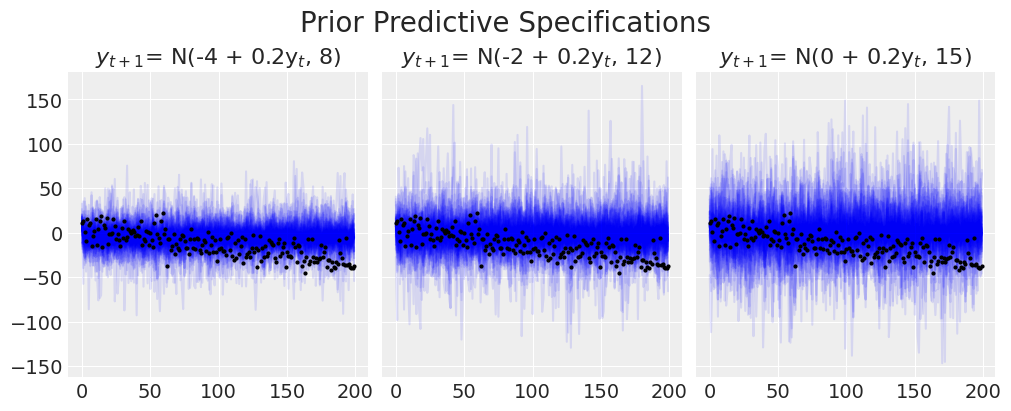

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
axs = axs.flatten()
for i, p in zip(range(3), [priors_0, priors_1, priors_2]):
    axs[i].plot(
        az.extract_dataset(models[i]["idata"], group="prior_predictive", num_samples=100)[
            "likelihood"
        ],
        color="blue",
        alpha=0.1,
    )
    axs[i].plot(y_t, "o", color="black", markersize=2)
    axs[i].set_title(
        "$y_{t+1}$" + f'= N({p["coefs"]["mu"][0]} + {p["coefs"]["mu"][1]}y$_t$, {p["sigma"]})'
    )
plt.suptitle("Prior Predictive Specifications", fontsize=20);

We can see the manner in which the model struggles to capture the trend line. Increasing the variability of the model will never capture the directional pattern we know to be in the data.

In [18]:
priors_0 = {
    "coefs": {"mu": [-4, 0.2], "sigma": [0.5, 0.03], "size": 2},
    "sigma": 8,
    "init": {"mu": -4, "sigma": 0.1, "size": 1},
}

idata_no_trend, preds_no_trend, model = make_latent_AR_model(y_t, priors_0)

Sampling: [ar, coefs, likelihood, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coefs, sigma, ar]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 41 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [likelihood]


Sampling: [ar1_fut, likelihood, yhat_fut]


/var/tmp/ipykernel_3009/119498147.py:12: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(idata_ar, group="prior_predictive", num_samples=1000)["likelihood"],
/var/tmp/ipykernel_3009/119498147.py:17: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(idata_ar, group="prior_predictive", num_samples=1000)["likelihood"],
/var/tmp/ipykernel_3009/119498147.py:31: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(idata_ar, group="prior_predictive", num_samples=1000)["likelihood"].mean(
/var/tmp/ipykernel_3009/119498147.py:49: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(idata_preds, group="predictions", num_samples=1000)["likelihood"],
/var/tmp/ipykernel_3009/119498147.py:54: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(idata_preds, group="predictions", num_samples=1000)["lik

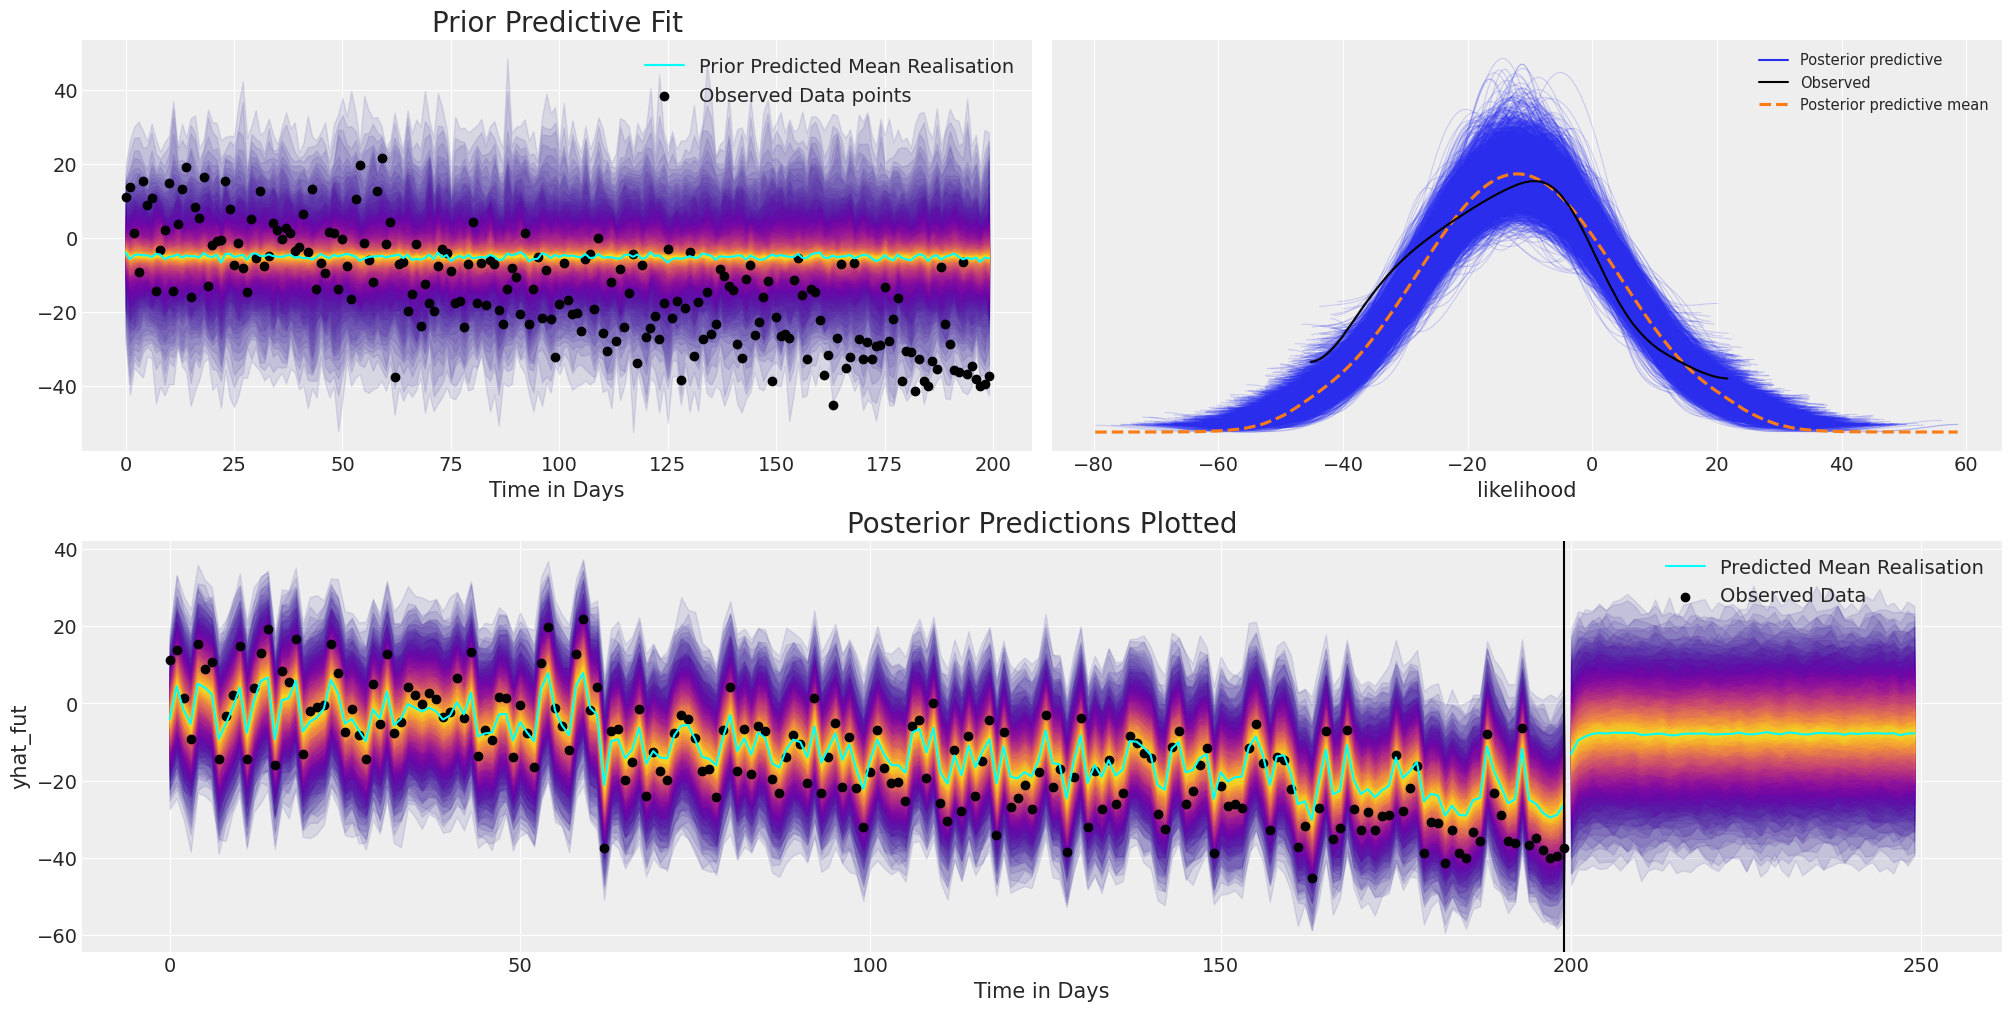

In [19]:
plot_fits(idata_no_trend, preds_no_trend)

While the model fits adjusts well with observed data, it completely fails to capture the strucutral trend in the data. So without some structural constraint when we seek to make predictions with this simple AR model, it reverts to the mean elvel forecast very quickly.

## Specifying a Trend Model